In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import load_data
import argparse
import os.path
import sys
import time
import subprocess
import math 
import os
import random
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import csv
import sklearn
from sklearn.cluster import MeanShift, estimate_bandwidth, KMeans, Birch
from sklearn.decomposition import PCA, FastICA, TruncatedSVD
import numpy as np
from scipy.spatial import distance_matrix
from scipy.spatial.distance import cosine

from six.moves import xrange
import tensorflow as tf
from tensorflow.python.framework import dtypes

C:\Users\pages\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Load the Ornate model
Please modify the path to restore file to match the place where the pre-trained Ornate model is stored
The paths in the file "checkpoint" in the model folder should also be modified 

In [2]:
    tf.Graph().as_default()
    sess = tf.Session()
    

    # Create a saver for writing training checkpoints.

    #restoreFile = "C:\\Users\\pages\\Downloads\\Model_NMA" #NMA trained
    restoreFile = "C:\\Users\\pages\\Documents\\CASP13\\src\\oriented3dCNN\\deepScoring\\models\\Model_ORNATE" #Ornate
    if (os.path.isdir(restoreFile)):
        dir(tf.contrib)
        print('Restore existing model: %s' % (restoreFile))
        print('Latest checkpoint: %s' % (tf.train.latest_checkpoint(restoreFile)))
        saver = tf.train.import_meta_graph(tf.train.latest_checkpoint(restoreFile) + '.meta')
        saver.restore(sess, tf.train.latest_checkpoint(restoreFile))
        print("Model restored!")
        graph = tf.get_default_graph()
        
        # getting placeholder for input data and output
        maps_placeholder = graph.get_tensor_by_name('main_input:0')
        is_training = graph.get_tensor_by_name('is_training:0')
        logits = graph.get_tensor_by_name("main_output:0")
        
        outByRoute = graph.get_tensor_by_name("transpose_1:0")
        outRouter = graph.get_tensor_by_name("out_router_1:0")
        retypedMap = graph.get_tensor_by_name("Reshape_2:0")
    else:
        # Add the variable initializer Op.
        print("No model provided")

Restore existing model: C:\Users\pages\Documents\CASP13\src\oriented3dCNN\deepScoring\models\Model_ORNATE
Latest checkpoint: C:\Users\pages\Documents\CASP13\src\oriented3dCNN\deepScoring\models\Model_ORNATE\model.ckpt
INFO:tensorflow:Restoring parameters from C:\Users\pages\Documents\CASP13\src\oriented3dCNN\deepScoring\models\Model_ORNATE\model.ckpt
Model restored!


# Find the retyper layer in the graph
Note that it contains 169 types instead of 167, two were used for debug purposes

In [3]:
for v in tf.global_variables() :
      if v.name == "retype_15:0" : 
        retype_val_raw = sess.run(v)
        retype_val_cropped = retype_val_raw[:167,:]
        print("Retyper found size : "+str(v.shape))
      if v.name == "weights_CONV_1_main_branche_15:0" :
        conv_1_val = sess.run(v)
        print("conv found size : "+str(v.shape))
retype_val = retype_val_cropped

Retyper found size : (169, 15)
conv found size : (3, 3, 3, 15, 20)


List all the atom types

In [4]:
typenames = ["ALA_C",
"ALA_N",
"ALA_O",
"ALA_CA",
"ALA_CB",
"ARG_C",
"ARG_N",
"ARG_O",
"ARG_CA",
"ARG_CB",
"ARG_CD",
"ARG_NE",
"ARG_CG",
"ARG_NH1",
"ARG_NH2",
"ARG_CZ",
"ASN_C",
"ASN_N",
"ASN_O",
"ASN_CA",
"ASN_CB",
"ASN_ND2",
"ASN_OD1",
"ASN_CG",
"ASP_C",
"ASP_N",
"ASP_O",
"ASP_CA",
"ASP_CB",
"ASP_OD1",
"ASP_OD2",
"ASP_CG",
"CYS_C",
"CYS_N",
"CYS_O",
"CYS_CA",
"CYS_CB",
"CYS_SG",
"GLN_C",
"GLN_N",
"GLN_O",
"GLN_CA",
"GLN_CB",
"GLN_CD",
"GLN_NE2",
"GLN_OE1",
"GLN_CG",
"GLU_C",
"GLU_N",
"GLU_O",
"GLU_CA",
"GLU_CB",
"GLU_CD",
"GLU_OE1",
"GLU_OE2",
"GLU_CG",
"GLY_C",
"GLY_N",
"GLY_O",
"GLY_CA",
"HIS_C",
"HIS_N",
"HIS_O",
"HIS_CA",
"HIS_CB",
"HIS_CD2",
"HIS_ND1",
"HIS_CE1",
"HIS_NE2",
"HIS_CG",
"ILE_C",
"ILE_N",
"ILE_O",
"ILE_CA",
"ILE_CB",
"ILE_CD1",
"ILE_CG1",
"ILE_CG2",
"LEU_C",
"LEU_N",
"LEU_O",
"LEU_CA",
"LEU_CB",
"LEU_CD1",
"LEU_CD2",
"LEU_CG",
"LYS_C",
"LYS_N",
"LYS_O",
"LYS_CA",
"LYS_CB",
"LYS_CD",
"LYS_CE",
"LYS_CG",
"LYS_NZ",
"MET_C",
"MET_N",
"MET_O",
"MET_CA",
"MET_CB",
"MET_CE",
"MET_CG",
"MET_SD",
"PHE_C",
"PHE_N",
"PHE_O",
"PHE_CA",
"PHE_CB",
"PHE_CD1",
"PHE_CD2",
"PHE_CE1",
"PHE_CE2",
"PHE_CG",
"PHE_CZ",
"PRO_C",
"PRO_N",
"PRO_O",
"PRO_CA",
"PRO_CB",
"PRO_CD",
"PRO_CG",
"SER_C",
"SER_N",
"SER_O",
"SER_CA",
"SER_CB",
"SER_OG",
"THR_C",
"THR_N",
"THR_O",
"THR_CA",
"THR_CB",
"THR_CG2",
"THR_OG1",
"TRP_C",
"TRP_N",
"TRP_O",
"TRP_CA",
"TRP_CB",
"TRP_CD1",
"TRP_CD2",
"TRP_CE2",
"TRP_CE3",
"TRP_NE1",
"TRP_CG",
"TRP_CH2",
"TRP_CZ2",
"TRP_CZ3",
"TYR_C",
"TYR_N",
"TYR_O",
"TYR_CA",
"TYR_CB",
"TYR_CD1",
"TYR_CD2",
"TYR_CE1",
"TYR_CE2",
"TYR_CG",
"TYR_OH",
"TYR_CZ",
"VAL_C",
"VAL_N",
"VAL_O",
"VAL_CA",
"VAL_CB",
"VAL_CG1",
"VAL_CG2",
"END_OXT",
"NULL"]
print(typenames)

['ALA_C', 'ALA_N', 'ALA_O', 'ALA_CA', 'ALA_CB', 'ARG_C', 'ARG_N', 'ARG_O', 'ARG_CA', 'ARG_CB', 'ARG_CD', 'ARG_NE', 'ARG_CG', 'ARG_NH1', 'ARG_NH2', 'ARG_CZ', 'ASN_C', 'ASN_N', 'ASN_O', 'ASN_CA', 'ASN_CB', 'ASN_ND2', 'ASN_OD1', 'ASN_CG', 'ASP_C', 'ASP_N', 'ASP_O', 'ASP_CA', 'ASP_CB', 'ASP_OD1', 'ASP_OD2', 'ASP_CG', 'CYS_C', 'CYS_N', 'CYS_O', 'CYS_CA', 'CYS_CB', 'CYS_SG', 'GLN_C', 'GLN_N', 'GLN_O', 'GLN_CA', 'GLN_CB', 'GLN_CD', 'GLN_NE2', 'GLN_OE1', 'GLN_CG', 'GLU_C', 'GLU_N', 'GLU_O', 'GLU_CA', 'GLU_CB', 'GLU_CD', 'GLU_OE1', 'GLU_OE2', 'GLU_CG', 'GLY_C', 'GLY_N', 'GLY_O', 'GLY_CA', 'HIS_C', 'HIS_N', 'HIS_O', 'HIS_CA', 'HIS_CB', 'HIS_CD2', 'HIS_ND1', 'HIS_CE1', 'HIS_NE2', 'HIS_CG', 'ILE_C', 'ILE_N', 'ILE_O', 'ILE_CA', 'ILE_CB', 'ILE_CD1', 'ILE_CG1', 'ILE_CG2', 'LEU_C', 'LEU_N', 'LEU_O', 'LEU_CA', 'LEU_CB', 'LEU_CD1', 'LEU_CD2', 'LEU_CG', 'LYS_C', 'LYS_N', 'LYS_O', 'LYS_CA', 'LYS_CB', 'LYS_CD', 'LYS_CE', 'LYS_CG', 'LYS_NZ', 'MET_C', 'MET_N', 'MET_O', 'MET_CA', 'MET_CB', 'MET_CE', 'MET_CG',

# Cluster the atom types


In [5]:
nCluster = 20
km = KMeans(n_clusters = nCluster, n_init = 200, random_state=1)
km.fit(retype_val)
labels = km.labels_
print(labels)
for k in range(167):
    print(labels[k])

labels_ordered = labels

[ 2  7  6  7 19  2 12  6 14 10 14  1  1 18 18  7 12  0  6  2 17 18  9 17
  7  0  6  7 17  9  9 17  7 12  3  8  4  4  2 11  6  7 10 14 18  9  1  2
  7  6  7 10 14  9  9  1  4  0  6 17  7  0  6  2  1  7  3 18 18  1  9 14
  9  2 11 12 11 12  8 14  9  8 11 12 12 11 12  7  9 12 10 18  5  1  5  9
 14  3  8  8  7 11 12  1 14  6  8  8 12 11  7 12 15 12  6 16  6  0  1 13
  1  7 11  6  7 17  3  7  1  6  7 17 11  3  8 14  9  8  8 11 15  3 11 18
 15 12  7 12  1 14  6  8  8 12 11  0 11 15 18  3  2 14  9  2 11 12 12]
2
7
6
7
19
2
12
6
14
10
14
1
1
18
18
7
12
0
6
2
17
18
9
17
7
0
6
7
17
9
9
17
7
12
3
8
4
4
2
11
6
7
10
14
18
9
1
2
7
6
7
10
14
9
9
1
4
0
6
17
7
0
6
2
1
7
3
18
18
1
9
14
9
2
11
12
11
12
8
14
9
8
11
12
12
11
12
7
9
12
10
18
5
1
5
9
14
3
8
8
7
11
12
1
14
6
8
8
12
11
7
12
15
12
6
16
6
0
1
13
1
7
11
6
7
17
3
7
1
6
7
17
11
3
8
14
9
8
8
11
15
3
11
18
15
12
7
12
1
14
6
8
8
12
11
0
11
15
18
3
2
14
9
2
11
12
12


# SVD decomposition of atom types

In [6]:

retypeVal_ch = np.concatenate((retype_val[:167,:],np.zeros((167,1))), axis=1)
X_reduced = TruncatedSVD(n_components =15).fit_transform(retypeVal_ch[:167,:])
pca = TruncatedSVD(n_components  = 15).fit(retypeVal_ch[:167,:])
u,s,vh = np.linalg.svd(retype_val[:167,:])
print(s)
print(pca.singular_values_)
print(u.shape)
print(vh.shape)
print(vh)
print(pca.components_)
xVariance = 0
for k in range(15):
    xVariance +=np.linalg.norm(X_reduced[:,k])**2
print(xVariance)
X_reduced /= math.sqrt(xVariance)
print("+++++++++++")
for k in range(15) : 
    print(np.mean(X_reduced[:,k]))
print("+++++++++++")
sumVarianceExplained = 0
print("Variance explained & " , end='')
for k in range(15) :
    sumVarianceExplained += np.linalg.norm(X_reduced[:,k])**2
    print("%2d & %.1f \\%%  & %.1f \\%% \\\\ " % (k+1, 100*np.linalg.norm(X_reduced[:,k])**2, 100*sumVarianceExplained))
print(" ")

for i in range(167):
    print(typenames[i], end='')
    for k in range(15) :
        
        print("\t %.5f " % (X_reduced[i,k]*math.sqrt(167)), end='')
    print(" ")


[1.0710633  1.004461   0.7691983  0.6892065  0.61952704 0.5438113
 0.49931484 0.39681557 0.35182932 0.2743685  0.23529683 0.2165695
 0.16238037 0.13750938 0.12269039]
[1.07106324 1.00446107 0.76919828 0.68920649 0.61952706 0.54381131
 0.49931484 0.39681557 0.35182931 0.27436849 0.23529683 0.2165695
 0.16238036 0.13750937 0.12269039]
(167, 167)
(15, 15)
[[ 1.91686079e-01 -2.97013968e-01 -3.24649885e-02 -2.85665482e-01
   1.10380158e-01 -2.59958833e-01 -1.09095454e-01 -2.30147764e-01
  -2.04652801e-01 -5.11555851e-01 -1.67617381e-01 -4.55862358e-02
  -1.29407167e-01 -2.94381768e-01  4.58906859e-01]
 [ 9.73043367e-02  2.23511368e-01 -1.58299636e-02 -3.67628708e-02
   3.66601229e-01  1.49222836e-01 -2.89342999e-01  4.43547815e-01
  -3.71515304e-01  1.21294923e-01  2.94590384e-01  2.66897768e-01
   1.09093040e-01 -4.11174923e-01  1.00669608e-01]
 [-3.13274771e-01  8.73198062e-02  5.46735346e-01  1.08955689e-01
   1.78488106e-01  2.94765830e-01 -7.72630498e-02 -4.22809273e-02
  -1.78522281e-

ILE_O	 0.90731 	 -0.19923 	 0.32546 	 -0.32376 	 0.00761 	 -0.23595 	 0.23638 	 0.01128 	 -0.05174 	 -0.07375 	 -0.19412 	 -0.01930 	 -0.05379 	 -0.06254 	 -0.04838  
ILE_CA	 -0.00741 	 0.34494 	 0.40083 	 -0.28571 	 -0.00565 	 -0.19489 	 0.00101 	 -0.02886 	 0.05580 	 0.05803 	 0.03170 	 -0.01689 	 -0.04436 	 -0.01884 	 0.06300  
ILE_CB	 -0.50597 	 0.76647 	 0.03797 	 -0.47976 	 0.19422 	 -0.40089 	 -0.09016 	 -0.10665 	 -0.01263 	 0.10803 	 0.09624 	 -0.00823 	 -0.06461 	 0.02730 	 0.03196  
ILE_CD1	 -0.50051 	 0.17052 	 0.33035 	 -0.24008 	 -0.10344 	 0.10797 	 -0.00787 	 0.05387 	 0.13122 	 -0.04737 	 0.10638 	 -0.02034 	 0.03709 	 -0.02301 	 -0.08276  
ILE_CG1	 -0.84979 	 0.26625 	 -0.13576 	 0.03759 	 0.18770 	 -0.26043 	 -0.05023 	 -0.02416 	 0.09885 	 -0.02990 	 0.26716 	 -0.05773 	 0.00028 	 -0.04721 	 -0.00077  
ILE_CG2	 -0.90289 	 0.01400 	 0.28468 	 -0.04363 	 -0.04372 	 0.00329 	 0.14288 	 -0.27190 	 -0.28656 	 0.05471 	 -0.07872 	 0.08273 	 -0.11799 	 -0.14280 	 -0.02339 

<IPython.core.display.Javascript object>


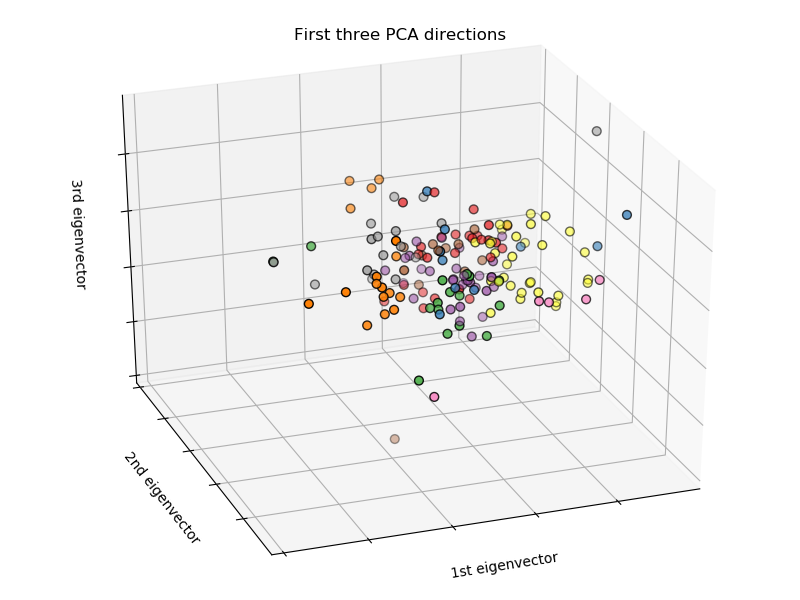

0.0014523731664077939
0.00089004292003783
0.000707738062701232


In [8]:
%matplotlib notebook
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)

ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=labels_ordered[:167],
           cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])
ax.set_xlim(np.amin(X_reduced), np.amax(X_reduced))
ax.set_ylim(np.amin(X_reduced), np.amax(X_reduced))
ax.set_zlim(np.amin(X_reduced), np.amax(X_reduced))
print(np.var(X_reduced[:,0]))
print(np.var(X_reduced[:,1]))
print(np.var(X_reduced[:,2]))
plt.show()

In [9]:

retypeOrdered = []
nameOrdered = []
labelsOrdered = []
for i in range(nCluster):
    for j in range(len(retype_val)):
        if labels[j] == i:
            retypeOrdered.append(retype_val[j])
            nameOrdered.append(typenames[j])
            labelsOrdered.append(labels_ordered[j])
retypeOrdered = np.vstack( retypeOrdered)

# Print clustering

In [10]:
oldLabel = 0
n = 0
myCluster=[]
currentCluster=[]
for k in labelsOrdered : 
    if k != oldLabel :
        print("-------------------- %d"%n)
        oldLabel = k
        myCluster.append(currentCluster)
        currentCluster=[]
    currentCluster.append(nameOrdered[n])
    print(nameOrdered[n])
    n+=1

myCluster.append(currentCluster)
currentCluster=[]
myCluster


ASN_N
ASP_N
GLY_N
HIS_N
PRO_CA
TYR_CE1
-------------------- 6
ARG_NE
ARG_CG
GLN_CG
GLU_CG
HIS_CB
HIS_CG
LYS_CG
PHE_C
PRO_CB
PRO_CG
THR_N
TYR_C
-------------------- 18
ALA_C
ARG_C
ASN_CA
GLN_C
GLU_C
HIS_CA
ILE_CA
VAL_C
VAL_CA
-------------------- 27
CYS_O
HIS_ND1
MET_O
SER_OG
THR_OG1
TRP_CE2
TYR_CZ
-------------------- 34
CYS_CB
CYS_SG
GLY_C
-------------------- 37
LYS_CE
LYS_NZ
-------------------- 39
ALA_O
ARG_O
ASN_O
ASP_O
GLN_O
GLU_O
GLY_O
HIS_O
PHE_O
PRO_C
PRO_O
SER_O
THR_O
TYR_O
-------------------- 53
ALA_N
ALA_CA
ARG_CZ
ASP_C
ASP_CA
CYS_C
GLN_CA
GLU_N
GLU_CA
HIS_C
HIS_CD2
LYS_N
MET_CE
PHE_CE1
SER_C
SER_CA
THR_C
THR_CA
TRP_CZ2
-------------------- 72
CYS_CA
LEU_C
LEU_CA
MET_CA
MET_CB
PHE_CA
PHE_CB
TRP_C
TRP_CA
TRP_CB
TYR_CA
TYR_CB
-------------------- 84
ASN_OD1
ASP_OD1
ASP_OD2
GLN_OE1
GLU_OE1
GLU_OE2
ILE_C
ILE_O
LEU_O
LYS_O
MET_C
TRP_O
VAL_O
-------------------- 97
ARG_CB
GLN_CB
GLU_CB
LYS_CB
-------------------- 101
GLN_N
ILE_CB
ILE_CG1
LEU_CB
LEU_CG
MET_CG
PHE_CD2
SER_N
THR_CG

[['ASN_N', 'ASP_N', 'GLY_N', 'HIS_N', 'PRO_CA', 'TYR_CE1'],
 ['ARG_NE',
  'ARG_CG',
  'GLN_CG',
  'GLU_CG',
  'HIS_CB',
  'HIS_CG',
  'LYS_CG',
  'PHE_C',
  'PRO_CB',
  'PRO_CG',
  'THR_N',
  'TYR_C'],
 ['ALA_C',
  'ARG_C',
  'ASN_CA',
  'GLN_C',
  'GLU_C',
  'HIS_CA',
  'ILE_CA',
  'VAL_C',
  'VAL_CA'],
 ['CYS_O', 'HIS_ND1', 'MET_O', 'SER_OG', 'THR_OG1', 'TRP_CE2', 'TYR_CZ'],
 ['CYS_CB', 'CYS_SG', 'GLY_C'],
 ['LYS_CE', 'LYS_NZ'],
 ['ALA_O',
  'ARG_O',
  'ASN_O',
  'ASP_O',
  'GLN_O',
  'GLU_O',
  'GLY_O',
  'HIS_O',
  'PHE_O',
  'PRO_C',
  'PRO_O',
  'SER_O',
  'THR_O',
  'TYR_O'],
 ['ALA_N',
  'ALA_CA',
  'ARG_CZ',
  'ASP_C',
  'ASP_CA',
  'CYS_C',
  'GLN_CA',
  'GLU_N',
  'GLU_CA',
  'HIS_C',
  'HIS_CD2',
  'LYS_N',
  'MET_CE',
  'PHE_CE1',
  'SER_C',
  'SER_CA',
  'THR_C',
  'THR_CA',
  'TRP_CZ2'],
 ['CYS_CA',
  'LEU_C',
  'LEU_CA',
  'MET_CA',
  'MET_CB',
  'PHE_CA',
  'PHE_CB',
  'TRP_C',
  'TRP_CA',
  'TRP_CB',
  'TYR_CA',
  'TYR_CB'],
 ['ASN_OD1',
  'ASP_OD1',
  'ASP_OD2',
  'G

In [11]:
from clusim.clustering import Clustering, print_clustering
import clusim.sim as sim

DendroPY not supported.


# IT-Score clustering

In [12]:
clusterHuang=[["ARG_CZ"],
              ["ASP_CG","GLU_CD"],
              ["ALA_C","ASN_C","ASP_C","ARG_C","CYS_C","GLN_C","GLU_C","GLY_C","HIS_C","ILE_C","LEU_C","LYS_C","MET_C","PHE_C","PRO_C","SER_C","THR_C","TRP_C","TYR_C","VAL_C"],
              ["ASN_CG","GLN_CD"],
              ["HIS_CD2", "HIS_CE1", "HIS_CG", "PHE_CD1", "PHE_CD2", "PHE_CE1", "PHE_CE2", "PHE_CG", "PHE_CZ", "TRP_CD1", "TRP_CD2", "TRP_CE2", "TRP_CE3", "TRP_CG", "TRP_CH2", "TRP_CZ2", "TRP_CZ3", "TYR_CD1", "TYR_CD2", "TYR_CE1", "TYR_CE2", "TYR_CG", "TYR_CZ"],
              ["ALA_CB", "ARG_CB", "ARG_CG", "ASN_CB", "ASP_CB", "GLN_CB", "GLN_CG", "GLU_CB", "GLU_CG", "HIS_CB", "ILE_CB", "ILE_CD1", "ILE_CG1", "ILE_CG2", "LEU_CB", "LEU_CD1", "LEU_CD2", "LEU_CG", "LYS_CB", "LYS_CD", "LYS_CG", "MET_CB", "PHE_CB", "PRO_CB", "PRO_CG", "SER_CB", "THR_CG2", "TRP_CB", "TYR_CB", "VAL_CB", "VAL_CG1", "VAL_CG2"],
              ["ALA_CA","ASN_CA","ASP_CA","ARG_CA","CYS_CA","GLN_CA","GLU_CA","GLY_CA","HIS_CA","ILE_CA","LEU_CA","LYS_CA","MET_CA","PHE_CA","PRO_CA","SER_CA","THR_CA","TRP_CA","TYR_CA","VAL_CA"],
              ["ARG_CD", "CYS_CB", "LYS_CE", "MET_CE", "MET_CG", "PRO_CD", "THR_CB"],
              ["ALA_N","ASN_N","ASP_N","ARG_N","CYS_N","GLN_N","GLU_N","GLY_N","HIS_N","ILE_N","LEU_N","LYS_N","MET_N","PHE_N","PRO_N","SER_N","THR_N","TRP_N","TYR_N","VAL_N"],
              ["ASN_ND2", "GLN_NE2"],
              ["HIS_ND1", "HIS_NE2", "TRP_NE1"],
              ["ARG_NH1", "ARG_NH2"],
              ["ARG_NE"],
              ["LYS_NZ"],
              ["ALA_O","ASN_O","ASP_O","ARG_O","CYS_O","GLN_O","GLU_O","GLY_O","HIS_O","ILE_O","LEU_O","LYS_O","MET_O","PHE_O","PRO_O","SER_O","THR_O","TRP_O","TYR_O","VAL_O"],
              ["ASN_OD1", "GLN_OE1"],
              ["SER_OG", "THR_OG1", "TYR_OH"],
              ["ASP_OD1","ASP_OD2", "GLU_OE1", "GLU_OE2"],
              ["CYS_SG"],
              ["MET_SD"]]

In [13]:
MyClu = Clustering()
MyClu.from_membership_list(labels)
print_clustering(MyClu)
print(labels)

len(labels)

016016353873471963|3216531001304111015481245014687241212760127|12925874010549181141161502612362|4|33153165610216675108771111611314583841478689|9616171810410431357952149|9425190|64128691031112461481185512093|67684413141432191158|17117251556157|1312023592812531|1627072136458053225488293095|973466133141126159|9899351341371061071387881151152|563637|1321011643915474139761091428285122156|9294|112140144157|115|119
[ 2  7  6  7 19  2 12  6 14 10 14  1  1 18 18  7 12  0  6  2 17 18  9 17
  7  0  6  7 17  9  9 17  7 12  3  8  4  4  2 11  6  7 10 14 18  9  1  2
  7  6  7 10 14  9  9  1  4  0  6 17  7  0  6  2  1  7  3 18 18  1  9 14
  9  2 11 12 11 12  8 14  9  8 11 12 12 11 12  7  9 12 10 18  5  1  5  9
 14  3  8  8  7 11 12  1 14  6  8  8 12 11  7 12 15 12  6 16  6  0  1 13
  1  7 11  6  7 17  3  7  1  6  7 17 11  3  8 14  9  8  8 11 15  3 11 18
 15 12  7 12  1 14  6  8  8 12 11  0 11 15 18  3  2 14  9  2 11 12 12]


167

In [14]:
HuangLabels = []
for k in typenames :
    for j in range(len(clusterHuang)) :
        if k in clusterHuang[j] :
            HuangLabels.append(j)
HuangClu = Clustering()
HuangClu.from_membership_list(HuangLabels)
print(HuangLabels)
len(HuangLabels)

[2, 8, 14, 6, 5, 2, 8, 14, 6, 5, 7, 12, 5, 11, 11, 0, 2, 8, 14, 6, 5, 9, 15, 3, 2, 8, 14, 6, 5, 17, 17, 1, 2, 8, 14, 6, 7, 18, 2, 8, 14, 6, 5, 3, 9, 15, 5, 2, 8, 14, 6, 5, 1, 17, 17, 5, 2, 8, 14, 6, 2, 8, 14, 6, 5, 4, 10, 4, 10, 4, 2, 8, 14, 6, 5, 5, 5, 5, 2, 8, 14, 6, 5, 5, 5, 5, 2, 8, 14, 6, 5, 5, 7, 5, 13, 2, 8, 14, 6, 5, 7, 7, 19, 2, 8, 14, 6, 5, 4, 4, 4, 4, 4, 4, 2, 8, 14, 6, 5, 7, 5, 2, 8, 14, 6, 5, 16, 2, 8, 14, 6, 7, 5, 16, 2, 8, 14, 6, 5, 4, 4, 4, 4, 10, 4, 4, 4, 4, 2, 8, 14, 6, 5, 4, 4, 4, 4, 4, 16, 4, 2, 8, 14, 6, 5, 5, 5]


167

# Jaccard index between clusterings

In [15]:
sim.count_pairwise_cooccurence(HuangClu,MyClu)
print(sim.jaccard_index(HuangClu,MyClu))



0.13502304147465438


Stochastic test to determine the p-value of our similarity

In [17]:

sampJac = sim.sample_expected_sim(HuangClu, MyClu, measure='jaccard_index',
                                  random_model='num', keep_samples=True, n_samples = 10)
meanSampJac = np.mean(sampJac)
varSampJac = np.var(sampJac)

In [18]:
print(meanSampJac)
print(varSampJac)

print((sim.jaccard_index(HuangClu,MyClu)-meanSampJac) /math.sqrt(varSampJac))

0.02558613994935899
1.6058649473814164e-05
27.309218936435407


In [19]:
myVal = sim.jaccard_index(HuangClu,MyClu)

nSup = 0
for v in sampJac:
    if v > myVal :
        nSup +=1
print(nSup/len(sampJac))
print(len(sampJac))

0.0
100


In [20]:

print(sim.jaccard_index(HuangClu,MyClu))

0.13502304147465438


# Distribution of differences

In [21]:
distMat = distance_matrix(retypeOrdered, retypeOrdered)
#distMat = np.minimum(distMat,0.4)
#distMat = 1.2 - distMat


alldist = []
for k1 in range(len(distMat)):
    for k2 in range(k1+1,len(distMat)):
        alldist.append(distMat[k1][k2])
        
dMean = np.mean(alldist)

for k1 in range(len(alldist)):
    alldist[k1] = alldist[k1]/dMean
    
for k2 in range(len(retypeOrdered)):
    retypeOrdered[k2] = retypeOrdered[k2]/dMean
    
print("percentile 10 ",np.percentile(alldist,10))
print("percentile 1 ",np.percentile(alldist,1))

print(np.std(alldist))
print(np.mean(alldist))

percentile 10  0.6389588117599487
percentile 1  0.4309052169322968
0.30655771
1.0


C:\Users\pages\Anaconda3\lib\site-packages\scipy\spatial\kdtree.py:74: RuntimeWarning: invalid value encountered in sqrt
  return minkowski_distance_p(x, y, p)**(1./p)


# Differences between indistiguishable atoms

In [22]:

######################################################
# PRINT DIFFERENCES BETWEEN INDISTINGUISHABLE TYPES  #
######################################################
print("ARG NH1/2 ", distMat[nameOrdered.index("ARG_NH1")][nameOrdered.index("ARG_NH2")]/dMean)
print("ASP OD1/2 ", distMat[nameOrdered.index("ASP_OD1")][nameOrdered.index("ASP_OD2")]/dMean)
print("GLU OE1/2 ", distMat[nameOrdered.index("GLU_OE1")][nameOrdered.index("GLU_OE2")]/dMean)
print("PHE CD1/2 ", distMat[nameOrdered.index("PHE_CD1")][nameOrdered.index("PHE_CD2")]/dMean)
print("PHE CE1/2 ", distMat[nameOrdered.index("PHE_CE1")][nameOrdered.index("PHE_CE2")]/dMean)
print("TYR CD1/2 ", distMat[nameOrdered.index("TYR_CD1")][nameOrdered.index("TYR_CD2")]/dMean)
print("TYR CE1/2 ", distMat[nameOrdered.index("TYR_CE1")][nameOrdered.index("TYR_CE2")]/dMean)
#print("VAL CG1/2 ", distMat[nameOrdered.index("VAL_CG1")][nameOrdered.index("VAL_CG2")]/dMean)
#print("LEU CD1/2 ", distMat[nameOrdered.index("LEU_CD1")][nameOrdered.index("LEU_CD2")]/dMean)



ARG NH1/2  0.24544095
ASP OD1/2  0.9285156
GLU OE1/2  0.46565616
PHE CD1/2  0.49971533
PHE CE1/2  0.34064293
TYR CD1/2  0.6728132
TYR CE1/2  0.4496848


# Diameters of clusters

In [23]:
def printdiam(cluster):
    ltot = 0
    for k in cluster :
        clusterDiam = 0
        for k1 in k:
            for k2 in k:
                if distMat[nameOrdered.index(k1)][nameOrdered.index(k2)]> clusterDiam : 
                    clusterDiam = distMat[nameOrdered.index(k1)][nameOrdered.index(k2)]
        print("---------")
        print(clusterDiam/dMean)
        print(' '.join(k))

In [24]:

####################################################################
# PRINT DIAMETER OF CLUSTERS IN THE CLUSTERING SCHEME FROM ITSCORE #
####################################################################
printdiam(clusterHuang)
print("++++++++++++++++++++")
#####################################
# PRINT DIAMETER OF MERGED CLUSTERS #
#####################################
printdiam([clusterHuang[17],clusterHuang[15]+clusterHuang[17]])
print("++++++++++++++++++++")
printdiam([clusterHuang[10],clusterHuang[10]+clusterHuang[12]+clusterHuang[11]+clusterHuang[9]])
print("++++++++++++++++++++")
printdiam([["ALA_N","ASN_N","ASP_N","ARG_N","CYS_N","GLN_N","GLU_N","GLY_N","HIS_N","ILE_N","LEU_N","LYS_N","MET_N","PHE_N","PRO_N","SER_N","THR_N","TRP_N","TYR_N","VAL_N"],
              ["ALA_N","ASN_N","ASP_N","ARG_N","CYS_N","GLN_N","GLU_N","GLY_N","HIS_N","ILE_N","LEU_N","LYS_N","MET_N","PHE_N","SER_N","THR_N","TRP_N","TYR_N","VAL_N"]
              ])
print("++++++++++++++++++++")
#######################################################
# PRINT DIAMETER OF CLUSTERS IN OUR CLUSTERING SCHEME #
#######################################################
printdiam(myCluster)
myCluster

---------
0.0
ARG_CZ
---------
0.49489543
ASP_CG GLU_CD
---------
1.8716644
ALA_C ASN_C ASP_C ARG_C CYS_C GLN_C GLU_C GLY_C HIS_C ILE_C LEU_C LYS_C MET_C PHE_C PRO_C SER_C THR_C TRP_C TYR_C VAL_C
---------
0.56184906
ASN_CG GLN_CD
---------
1.3624566
HIS_CD2 HIS_CE1 HIS_CG PHE_CD1 PHE_CD2 PHE_CE1 PHE_CE2 PHE_CG PHE_CZ TRP_CD1 TRP_CD2 TRP_CE2 TRP_CE3 TRP_CG TRP_CH2 TRP_CZ2 TRP_CZ3 TYR_CD1 TYR_CD2 TYR_CE1 TYR_CE2 TYR_CG TYR_CZ
---------
2.152687
ALA_CB ARG_CB ARG_CG ASN_CB ASP_CB GLN_CB GLN_CG GLU_CB GLU_CG HIS_CB ILE_CB ILE_CD1 ILE_CG1 ILE_CG2 LEU_CB LEU_CD1 LEU_CD2 LEU_CG LYS_CB LYS_CD LYS_CG MET_CB PHE_CB PRO_CB PRO_CG SER_CB THR_CG2 TRP_CB TYR_CB VAL_CB VAL_CG1 VAL_CG2
---------
1.6393685
ALA_CA ASN_CA ASP_CA ARG_CA CYS_CA GLN_CA GLU_CA GLY_CA HIS_CA ILE_CA LEU_CA LYS_CA MET_CA PHE_CA PRO_CA SER_CA THR_CA TRP_CA TYR_CA VAL_CA
---------
2.1444051
ARG_CD CYS_CB LYS_CE MET_CE MET_CG PRO_CD THR_CB
---------
1.9424615
ALA_N ASN_N ASP_N ARG_N CYS_N GLN_N GLU_N GLY_N HIS_N ILE_N LEU_N LYS_N

[['ASN_N', 'ASP_N', 'GLY_N', 'HIS_N', 'PRO_CA', 'TYR_CE1'],
 ['ARG_NE',
  'ARG_CG',
  'GLN_CG',
  'GLU_CG',
  'HIS_CB',
  'HIS_CG',
  'LYS_CG',
  'PHE_C',
  'PRO_CB',
  'PRO_CG',
  'THR_N',
  'TYR_C'],
 ['ALA_C',
  'ARG_C',
  'ASN_CA',
  'GLN_C',
  'GLU_C',
  'HIS_CA',
  'ILE_CA',
  'VAL_C',
  'VAL_CA'],
 ['CYS_O', 'HIS_ND1', 'MET_O', 'SER_OG', 'THR_OG1', 'TRP_CE2', 'TYR_CZ'],
 ['CYS_CB', 'CYS_SG', 'GLY_C'],
 ['LYS_CE', 'LYS_NZ'],
 ['ALA_O',
  'ARG_O',
  'ASN_O',
  'ASP_O',
  'GLN_O',
  'GLU_O',
  'GLY_O',
  'HIS_O',
  'PHE_O',
  'PRO_C',
  'PRO_O',
  'SER_O',
  'THR_O',
  'TYR_O'],
 ['ALA_N',
  'ALA_CA',
  'ARG_CZ',
  'ASP_C',
  'ASP_CA',
  'CYS_C',
  'GLN_CA',
  'GLU_N',
  'GLU_CA',
  'HIS_C',
  'HIS_CD2',
  'LYS_N',
  'MET_CE',
  'PHE_CE1',
  'SER_C',
  'SER_CA',
  'THR_C',
  'THR_CA',
  'TRP_CZ2'],
 ['CYS_CA',
  'LEU_C',
  'LEU_CA',
  'MET_CA',
  'MET_CB',
  'PHE_CA',
  'PHE_CB',
  'TRP_C',
  'TRP_CA',
  'TRP_CB',
  'TYR_CA',
  'TYR_CB'],
 ['ASN_OD1',
  'ASP_OD1',
  'ASP_OD2',
  'G

# PLOT DISRTIBUTION OF DIFFERENCES

<IPython.core.display.Javascript object>


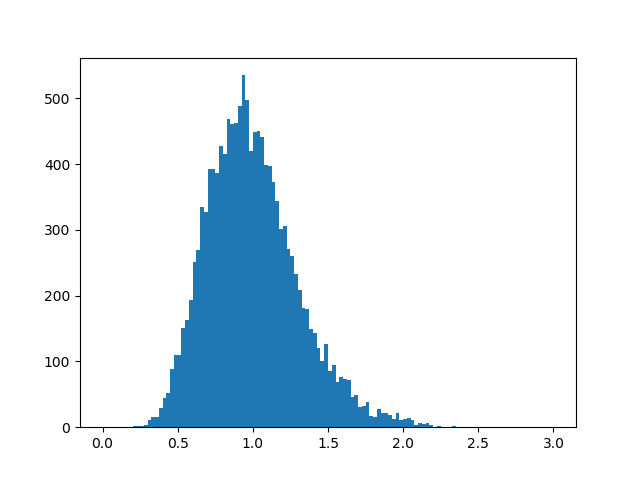

1244
74
13861
2.8293705


In [25]:
np.linalg.norm(retypeOrdered[nameOrdered.index("ASN_OD1")] - retypeOrdered[nameOrdered.index("ASN_ND2")] - retypeOrdered[nameOrdered.index("GLN_OE1")] + retypeOrdered[nameOrdered.index("GLN_NE2")])/dMean

####################################
# PLOT DISRTIBUTION OF DIFFERENCES #
####################################
bins = [];
cBin = 0;
while (cBin < 3):
    bins.append(cBin)
    cBin += 0.025
(n, bins, patches) = plt.hist(alldist, bins=bins, ec='none')

shortDist = [h for h in alldist if h <0.625]
print(len(shortDist))
longDist = [h for h in alldist if h >2]
print(len(longDist))
print(len(alldist))
plt.show()
print(np.max(alldist))

In [26]:
#constr=(retypeOrdered[nameOrdered.index("ASN_OD1")] - retypeOrdered[nameOrdered.index("ASN_ND2")] + retypeOrdered[nameOrdered.index("GLN_NE2")])
#constr=(retypeOrdered[nameOrdered.index("GLN_OE1")] - retypeOrdered[nameOrdered.index("ASN_OD1")] + retypeOrdered[nameOrdered.index("ASN_ND2")])
#constr=(retypeOrdered[nameOrdered.index("GLN_NE2")] - retypeOrdered[nameOrdered.index("GLN_OE1")] + retypeOrdered[nameOrdered.index("ASN_OD1")])
constr=(retypeOrdered[nameOrdered.index("ASN_ND2")] - retypeOrdered[nameOrdered.index("GLN_NE2")] + retypeOrdered[nameOrdered.index("GLU_OE1")]- retypeOrdered[nameOrdered.index("ASP_OD1")])

print(np.linalg.norm( constr))                                                                                       

0.6022973


# Statistic test for seven pairs of indistiguishable atoms

<IPython.core.display.Javascript object>


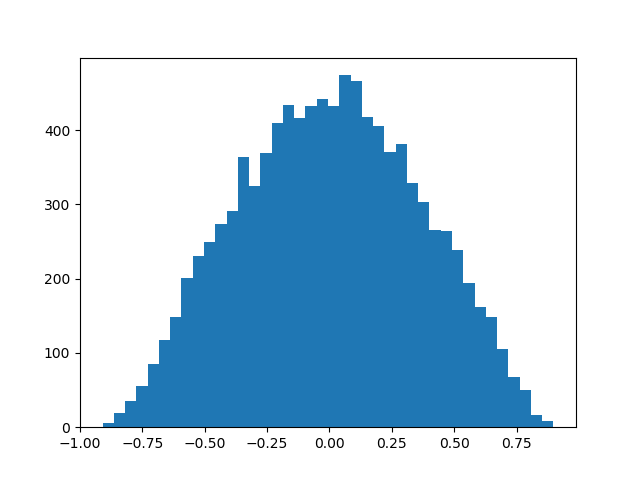

In [27]:
scaling = np.linalg.norm(X_reduced, axis=0)
cosHist=[]
for i in range(10000):
    x1 = np.random.normal(size=15)
    x2 = np.random.normal(size=15)
    cosHist.append(1-cosine(x1*scaling, x2*scaling))
plt.hist(cosHist, bins=40)
plt.show()

<IPython.core.display.Javascript object>


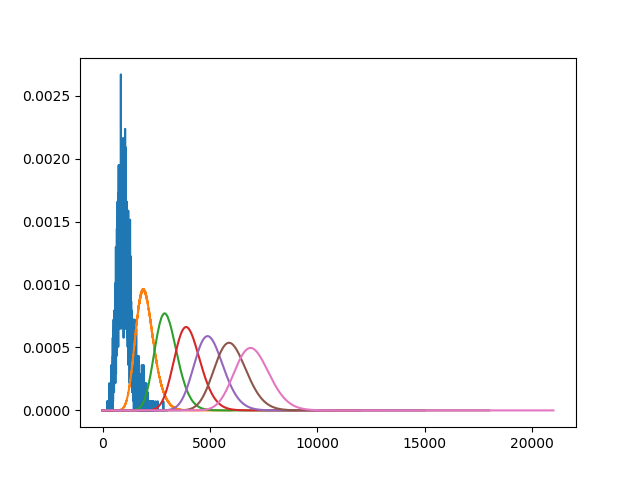

In [28]:

distmax = 3
nBins = 1000*distmax
histogram = np.zeros(nBins)
for i in alldist:
    histogram[int(i*nBins/distmax)]+=1
histogramC = [1]
for i in range(7):
    histogramC = np.convolve(histogramC,histogram)
    histogramC = histogramC/np.linalg.norm(histogramC,ord = 1)
    plt.plot(histogramC)

plt.show()

In [29]:
sumDist= distMat[nameOrdered.index("ARG_NH1")][nameOrdered.index("ARG_NH2")]/dMean+distMat[nameOrdered.index("ASP_OD1")][nameOrdered.index("ASP_OD2")]/dMean+ distMat[nameOrdered.index("GLU_OE1")][nameOrdered.index("GLU_OE2")]/dMean+ distMat[nameOrdered.index("PHE_CD1")][nameOrdered.index("PHE_CD2")]/dMean+ distMat[nameOrdered.index("PHE_CE1")][nameOrdered.index("PHE_CE2")]/dMean+ distMat[nameOrdered.index("TYR_CD1")][nameOrdered.index("TYR_CD2")]/dMean+ distMat[nameOrdered.index("TYR_CE1")][nameOrdered.index("TYR_CE2")]/dMean

In [30]:
############################################################################
# P-VALUE FOR FINDING 7 PAIRS AS CLOSE AS THE INDISTIGUISHABLE ATOMS PAIRS #
############################################################################
np.sum(histogramC[:int(1000*sumDist)])

1.20708376806468e-07

In [31]:
print(labelsOrdered)
oldLabel = 0
patchesPos=[]
patchesSize =[]
startPos = 0
for i in range(len(labelsOrdered)) :
    if not labelsOrdered[i] == oldLabel :
        patchesPos.append(startPos)
        patchesSize.append(i - startPos)
        startPos = i
        oldLabel = labelsOrdered[i]
        
patchesPos.append(startPos)
patchesSize.append(len(labelsOrdered) - startPos)

[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 16, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 18, 19]


# Difference map between atoms

<IPython.core.display.Javascript object>


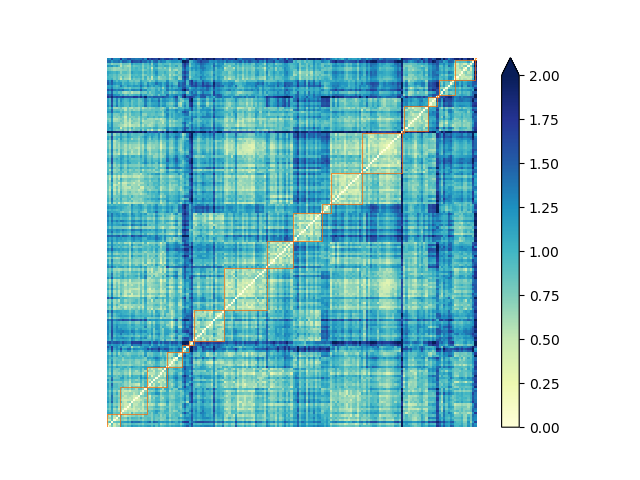

In [32]:
import matplotlib.patches as patches
fig, ax = plt.subplots()
distMatPlot = np.minimum(2, distMat/dMean)
im = ax.pcolormesh(distMatPlot, cmap=cm.YlGnBu)
ax.set_aspect(1)
ax.set_yticks([], minor=False)
ax.set_xticks([], minor=False)
cbar = fig.colorbar(im,extend ='max')
ax.set_frame_on(False)
for i in range(20):
    rect = patches.Rectangle((patchesPos[i],patchesPos[i]),patchesSize[i],patchesSize[i],linewidth=0.5,edgecolor=(1, 0.4, 0.),facecolor='none')
    ax.add_patch(rect)
#fig.patch.set_visible(False)
plt.show()


# Run Ornate on CASP 11 and 12 stage 1 and save the results 
Please change the paths to match your setup
Note that this part can take several hours

In [38]:
resList = ["A","C","D","E","F","G","H","I","K","L","M","N","P","Q","R","S","T","V","W","Y"]

In [41]:
modelList = ["E:/CASP13/data/CASP11_stage1/MODELS/" + p for p in os.listdir("E:/CASP13/data/CASP11_stage1/MODELS/")]+\
            ["E:/CASP13/data/CASP12_stage1/MODELS/" + p for p in os.listdir("E:/CASP13/data/CASP12_stage1/MODELS/")]
#modelList = ["E:/CASP13/data/CASP11_stage1/MODELS/T0788"]
start = True
for routingDirTest in modelList:
    if not start: continue
    #routingDirTest = "E:/CASP13/data/CASP11_stage1/MODELS/T0759"
    if not os.path.isdir(routingDirTest):
        continue
    TEMP_PATH = "R:/Temp/"
    NB_ROUTE = 22
    nbEmpty = tf.reduce_sum(tf.sign(tf.abs(tf.reduce_sum(retypedMap, axis=4))),axis=[1,2,3])
    fResult = open(routingDirTest+"/res.txt","w")
    
    for file in os.listdir(routingDirTest):
    
        if not file.endswith(".sco") and not file.endswith(".out") and not file.endswith(".txt") and not file.endswith(".ss"):
            filename = os.path.join(routingDirTest, file)
            print(filename, file=fResult)
            print(filename)
            mapFilename = TEMP_PATH + 'map_'+"jupyter"+ '_pred.bin'
            subprocess.call(
              ["C:/Users/pages/Documents/CASP13/src/oriented3dCNN/mapsGenerator/build/Release/maps_generator.exe",
               "--mode", "map", "-i", filename, "--native", "-m", "24","--atom_types","169", "-v", "0.8", "-o",
            mapFilename])
            subprocess.call(
              ["C:/Users/pages/Documents/CASP13/src/stride/build/Release/stride.exe",
                  "-f"+filename+".ss", filename])
           
            if not os.path.exists(mapFilename):
                print('# Mapping failed, ignoring protein')
                continue
            predDataset = load_data.read_data_set(mapFilename)
            batchSize = 60
            i = 0
            while (i * batchSize) < predDataset.num_res:
                limSup = min(batchSize*(i+1), predDataset.num_res)
                bs = limSup - (batchSize*i)
                f_map = np.reshape(predDataset.maps[batchSize*i:limSup], (bs, 24*24*24*169))
                feed_dict = {maps_placeholder: f_map, is_training: False}
                pred,routing,predRouter,nempt = sess.run([logits,outByRoute,outRouter, nbEmpty],feed_dict=feed_dict)
                for ii in range(bs):
                    #preds.append(pred)
                    index = batchSize*i+ii
                    #print(index)
                    #print(ii)
                    if (bs ==1):
                        prediction = pred
                    else:
                        prediction = pred[ii]
                    outline='RES {:4d} {:c} {:5.4f}'.format(predDataset.meta[index][0], ord(resList[predDataset.meta[index][1]]), prediction)
                    outline += ' {:5d} '.format(int(nempt[ii]))
                    
                    if (bs ==1):
                        route = routing
                    else:
                        route = routing[ii]
                        predRoute = predRouter[ii]
                    for n in range(NB_ROUTE) :
                        outline +=  ' {:5.4f} {:5.4f}'.format(route[n],predRouter[ii][n])
                    print(outline, file=fResult)
                i+=1

E:/CASP13/data/CASP11_stage1/MODELS/.ipynb_checkpoints\Untitled-checkpoint.ipynb
Extracting R:/Temp/map_jupyter_pred.bin
E:/CASP13/data/CASP11_stage1/MODELS/T0759\server01_TS1
Extracting R:/Temp/map_jupyter_pred.bin


KeyboardInterrupt: 